<a href="https://colab.research.google.com/github/selwyntarr/speech_emotion_recognition_model/blob/main/speech_emotion_recognition_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition Model

## Setup

In [ ]:
#connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
[Errno 2] No such file or directory: './drive/MyDrive/colab_files/ #directory for your datasets'
/content
drive  sample_data


In [ ]:
#move to directory
%cd ./drive/MyDrive/colab_files/

/content/drive/MyDrive/colab_files


In [ ]:
#check directory
!ls

 chest_xray    crema_d	     labels			    weathers.zip
 chest_xray2   crema-d.zip  'Multi-class Weather Dataset'


In [ ]:
#unzip Crema-D dataset
!unzip crema-d.zip -d .
%mv AudioWAV crema_d

In [ ]:
#install required libraries
%pip uninstall librosa
%pip install resampy
%pip install librosa

Found existing installation: librosa 0.10.0.post2
Uninstalling librosa-0.10.0.post2:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/librosa-0.10.0.post2.dist-info/*
    /usr/local/lib/python3.9/dist-packages/librosa/*
Proceed (Y/n)? Y
  Successfully uninstalled librosa-0.10.0.post2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached librosa-0.10.0.post2-py3-none-any.whl (253 kB)


In [ ]:
# import modules

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import glob 
import os
import pickle
import IPython.display as ipd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram

## Data Pre-Processing

In [ ]:
#separate all files to different sub directories

CREMA = './crema_d/' #your directory

dir_list = os.listdir(CREMA)
dir_list.sort()

gender = []
emotion = []
path = []

for i in dir_list: 
    part = i.split('_')
    if part[2] == 'SAD':
        emotion.append('sad')
    elif part[2] == 'ANG':
        emotion.append('angry')
    elif part[2] == 'DIS':
        emotion.append('disgust')
    elif part[2] == 'FEA':
        emotion.append('fear')
    elif part[2] == 'HAP':
        emotion.append('happy')
    elif part[2] == 'NEU':
        emotion.append('neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: labels, dtype: int64

In [ ]:
CREMA_df.head(10)

,labels,path
0,angry,./crema_d/1001_DFA_ANG_XX.wav
1,disgust,./crema_d/1001_DFA_DIS_XX.wav
2,fear,./crema_d/1001_DFA_FEA_XX.wav
3,happy,./crema_d/1001_DFA_HAP_XX.wav
4,neutral,./crema_d/1001_DFA_NEU_XX.wav
5,sad,./crema_d/1001_DFA_SAD_XX.wav
6,angry,./crema_d/1001_IEO_ANG_HI.wav
7,angry,./crema_d/1001_IEO_ANG_LO.wav
8,angry,./crema_d/1001_IEO_ANG_MD.wav
9,disgust,./crema_d/1001_IEO_DIS_HI.wav


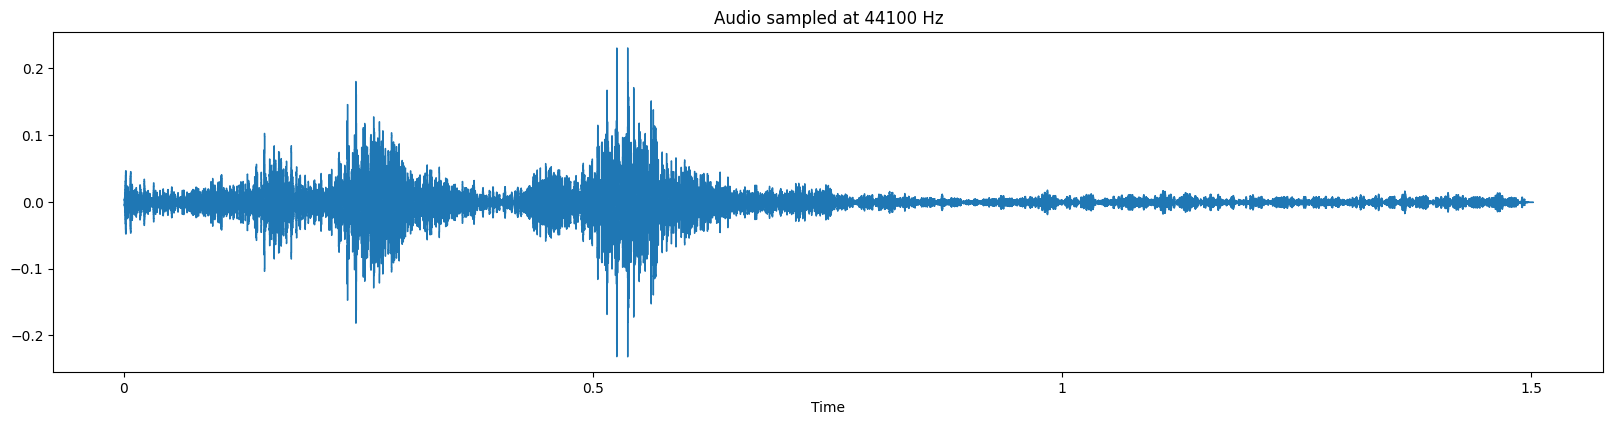

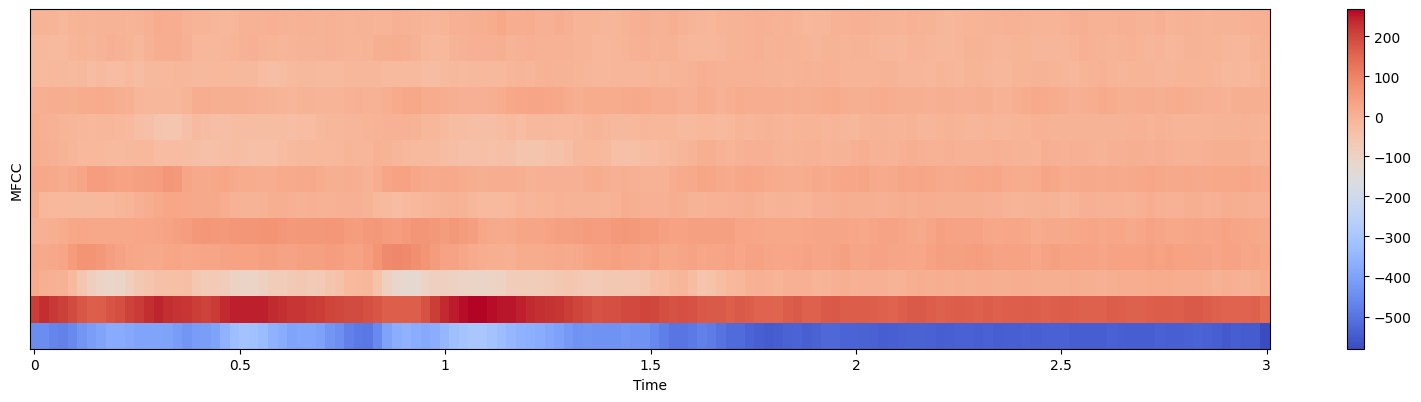

In [ ]:
#sample feature extraction
path = "./crema_d/1001_DFA_SAD_XX.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=2, sr=44100, offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveshow(X, sr=sample_rate)
plt.title('Audio sampled at 44100 Hz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [ ]:
# Create dataframe for features
FEATURES_df = pd.DataFrame(columns=['feature'])
FEATURES_df

,feature


In [ ]:
# Note this takes a couple of minutes (~10 mins)
# Loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(CREMA_df.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    FEATURES_df.loc[counter] = [mfccs]
    counter=counter+1   
    
    #status checker
    if counter == int(len(CREMA_df.path) * 0.25):
      print("EXTRACTING FEATURES..........25%")
    elif counter == int(len(CREMA_df.path) * 0.50):
      print("EXTRACTING FEATURES..........50%")
    elif counter == int(len(CREMA_df.path) * 0.75):
      print("EXTRACTING FEATURES..........75%")
    elif counter == int(len(CREMA_df.path) * 0.99):
      print("EXTRACTING FEATURES..........99%")
    elif counter == int(len(CREMA_df.path)):
      print("EXTRACTING FEATURES.........DONE")
    

EXTRACTING FEATURES..........25%
EXTRACTING FEATURES..........50%
EXTRACTING FEATURES..........75%
EXTRACTING FEATURES..........99%
EXTRACTING FEATURES.........DONE


In [ ]:
# Check a few records to make sure its processed successfully
print(len(FEATURES_df))
FEATURES_df.head()

7442


,feature
0,"[-5.2073154, -6.166905, -12.6587105, -14.03230..."
1,"[-24.97352, -22.904255, -21.25757, -19.612495,..."
2,"[-24.575413, -22.235098, -19.402586, -22.22992..."
3,"[-18.511417, -14.939599, -15.648182, -15.32823..."
4,"[-11.934254, -13.073408, -18.665142, -19.95993..."


In [ ]:
# Combine the features with labels
CremaD_dataset = pd.concat([CREMA_df,pd.DataFrame(FEATURES_df['feature'].values.tolist())],axis=1)

In [ ]:
CremaD_dataset.head()

,labels,path,0,1,2,3,4,5,6,7,...,163,164,165,166,167,168,169,170,171,172
0,angry,./crema_d/1001_DFA_ANG_XX.wav,-5.207315,-6.166905,-12.658710,-14.032304,-14.705481,-14.631962,-14.574433,-15.783544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,disgust,./crema_d/1001_DFA_DIS_XX.wav,-24.973520,-22.904255,-21.257570,-19.612495,-20.758669,-18.076595,-14.498128,-11.265459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fear,./crema_d/1001_DFA_FEA_XX.wav,-24.575413,-22.235098,-19.402586,-22.229919,-23.924299,-22.795601,-19.530411,-13.459636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,happy,./crema_d/1001_DFA_HAP_XX.wav,-18.511417,-14.939599,-15.648182,-15.328231,-14.744277,-15.508641,-15.924841,-14.706569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,neutral,./crema_d/1001_DFA_NEU_XX.wav,-11.934254,-13.073408,-18.665142,-19.959930,-19.346594,-20.770037,-22.096453,-21.387875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Fill Nan with zeroes
CremaD_dataset = CremaD_dataset.fillna(0)

In [ ]:
# Get train and test dataset
X_train, X_test, y_train, y_test = train_test_split(CremaD_dataset.drop(['path','labels'],axis=1)
                                                    , CremaD_dataset.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
3346,-19.207752,-14.688344,-14.056575,-13.782269,-14.294572,-13.481016,-14.035862,-13.425783,-12.122447,-10.401434,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3731,-17.040098,-18.206844,-16.761911,-15.160453,-15.855844,-15.645064,-13.424458,-13.836798,-14.605910,-15.664908,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3997,-17.585920,-17.607485,-16.729155,-17.389864,-16.556114,-16.003107,-15.903042,-17.048502,-17.737032,-19.906481,...,-18.152159,-18.042652,-21.223562,-21.314009,-20.692282,-17.830318,-18.778259,-19.374819,-17.821819,-18.736336
2742,-20.691895,-18.480663,-16.722954,-14.396310,-13.210069,-13.872313,-12.499882,-11.873235,-13.227438,-12.986304,...,-17.761595,-18.088663,-17.995298,-16.969839,-19.542370,-17.564505,-15.685873,-18.045105,-19.038740,-19.749861
2272,-18.269318,-17.039055,-16.780178,-17.536436,-18.147478,-17.315435,-15.582239,-14.278457,-16.116652,-19.892387,...,-17.854082,-17.115360,-16.893084,-16.247103,-16.411753,-17.652355,-17.200289,-16.806089,-16.718433,-19.670139


In [ ]:
# Data normalization
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,163,164,165,166,167,168,169,170,171,172
3346,-0.232954,0.434604,0.774638,0.830110,0.660744,0.875291,0.685509,0.848752,1.195319,1.682959,...,1.161960,1.100777,1.100944,1.098518,1.037778,1.038611,1.036478,0.987276,0.985683,0.978076
3731,0.177140,-0.436576,-0.005746,0.433589,0.209248,0.254640,0.859159,0.731797,0.491000,0.186368,...,1.161960,1.100777,1.100944,1.098518,1.037778,1.038611,1.036478,0.987276,0.985683,0.978076
3997,0.073877,-0.288175,0.003703,-0.207840,0.006740,0.151953,0.155197,-0.182097,-0.396998,-1.019659,...,-0.774711,-0.828269,-1.158456,-1.144473,-1.154126,-0.848132,-0.924697,-1.061078,-0.892175,-0.847556
2742,-0.513735,-0.504374,0.005492,0.653443,0.974366,0.763067,1.121755,1.290531,0.881940,0.947990,...,-0.733041,-0.833188,-0.814784,-0.687312,-1.032318,-0.820005,-0.601732,-0.920497,-1.020400,-0.946311
2272,-0.055413,-0.147432,-0.011015,-0.250010,-0.453458,-0.224424,0.246311,0.606123,0.062548,-1.015652,...,-0.742908,-0.729127,-0.697446,-0.611255,-0.700696,-0.829301,-0.759896,-0.789505,-0.775912,-0.938544


In [ ]:
# Convert to numpy array
from keras.utils import np_utils

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Hot encoder
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(X_test.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(5581, 173)
(1861, 173)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


## SER model using CNN and LSTM

In [ ]:
from keras import layers
from keras import models

ser_model = models.Sequential()
ser_model.add(layers.Conv1D(128, 8, activation='relu', input_shape=(X_train.shape[1],1)))
ser_model.add(layers.MaxPooling1D(4))
ser_model.add(layers.Conv1D(64, 4, activation='relu'))
ser_model.add(layers.MaxPooling1D(4))
ser_model.add(layers.LSTM(64, return_sequences = True))
ser_model.add(layers.LSTM(32))
ser_model.add(layers.Dense(6, activation = 'softmax'))

In [ ]:
ser_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 166, 128)          1152      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 41, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 38, 64)            32832     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 9, 64)            0         
 g1D)                                                            
                                                                 
 lstm_18 (LSTM)              (None, 9, 64)             33024     
                                                                 
 lstm_19 (LSTM)              (None, 32)              

In [ ]:
from keras import optimizers
from keras import callbacks

# Compile model
opt = optimizers.RMSprop(learning_rate=0.001)

ser_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Save the best weights
checkpoint_path = './ser_best_weights.hdf5'
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                                     monitor='val_accuracy',
                                     mode='max',
                                     verbose=1
                                     )

# Reduce learning rate after 10 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                    factor=0.1, 
                                    patience=10
                                    )

# Train model
hist = ser_model.fit(X_train, y_train, 
                     epochs=20, 
                     batch_size=32,
                     shuffle=True,
                     validation_data=(X_test, y_test),
                     callbacks = [mcp_save, rlrop],
                     verbose=1
                    )

Epoch 1/20
175/175 [==============================] - 14s 55ms/step - loss: 1.6005 - accuracy: 0.3254 - val_loss: 1.7084 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 2/20
175/175 [==============================] - 7s 38ms/step - loss: 1.5686 - accuracy: 0.3487 - val_loss: 1.6043 - val_accuracy: 0.3455 - lr: 0.0010
Epoch 3/20
175/175 [==============================] - 9s 50ms/step - loss: 1.5414 - accuracy: 0.3571 - val_loss: 1.5858 - val_accuracy: 0.3498 - lr: 0.0010
Epoch 4/20
175/175 [==============================] - 10s 56ms/step - loss: 1.5300 - accuracy: 0.3641 - val_loss: 1.5864 - val_accuracy: 0.3536 - lr: 0.0010
Epoch 5/20
175/175 [==============================] - 8s 46ms/step - loss: 1.5173 - accuracy: 0.3684 - val_loss: 1.5334 - val_accuracy: 0.3616 - lr: 0.0010
Epoch 6/20
175/175 [==============================] - 7s 39ms/step - loss: 1.5070 - accuracy: 0.3838 - val_loss: 1.5342 - val_accuracy: 0.3778 - lr: 0.0010
Epoch 7/20
175/175 [==============================] - 8s 43ms/